In [1]:
import pprint
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
import torch.nn as nn
from functorch import vmap
from scipy.stats import wasserstein_distance
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torch import nn
from sklearn.decomposition import PCA
from Unet1D import Unet1D
from backbone import ConvBackbone1D
from tqdm import tqdm

In [2]:
import utils
import ddpmhelp
#import importlib
#importlib.reload(utils)
#importlib.reload(ddpmhelp)

<module 'ddpmhelp' from '/scratch/zt1/project/tiwary-prj/user/rjohn123/DDPMvsNF/ddpmhelp.py'>

In [3]:
class args:
    dataset_limiter = 1000
    filepath = 'array3.txt'
    split = np.array([0.8, 0.1, 0.1])
    batch_size = 512
    bounds = np.array([-3, 3, -3, 3])
    lr = 5e-4
    resnet_block_groups = 4
    learned_sinusoidal_dim = 16
    dim_mults=(1, 2, 4)
    diffusion_steps = 100
    sample_batching = 100

In [4]:
train_loader, train_np, valid_np, test_np, num_set = ddpmhelp.preprocess_samples(args.filepath, args.split, args.batch_size, args.dataset_limiter)
diffusion = ddpmhelp.VPDiffusion(num_diffusion_timesteps=args.diffusion_steps)
model, backbone, num_torsions = ddpmhelp.init_model_backbone(train_loader, args.resnet_block_groups, args.learned_sinusoidal_dim, args.dim_mults, num_set, args.lr)
pca = PCA(n_components=2)
trainingpca = pca.fit_transform(train_np)
generated_testing, info = ddpmhelp.train_and_sample(model, train_loader, valid_np, test_np, pca, args.bounds, diffusion, backbone, num_torsions, num_set, args.sample_batching)
pprint.pprint(info)

/scratch/zt1/project/tiwary-prj/user/rjohn123/micromamba/envs/testenv/lib/python3.12/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


{'Architecture': 'DDPM',
 'Dimensions': 10,
 'Final KLD': 1633.911715718554,
 'Final WD': 0.02333333333333292,
 'Iterations': 5,
 'Learnable parameters': 239529,
 'Speed (samples/s)': 16.277665514182296,
 'Training data amount': 800}


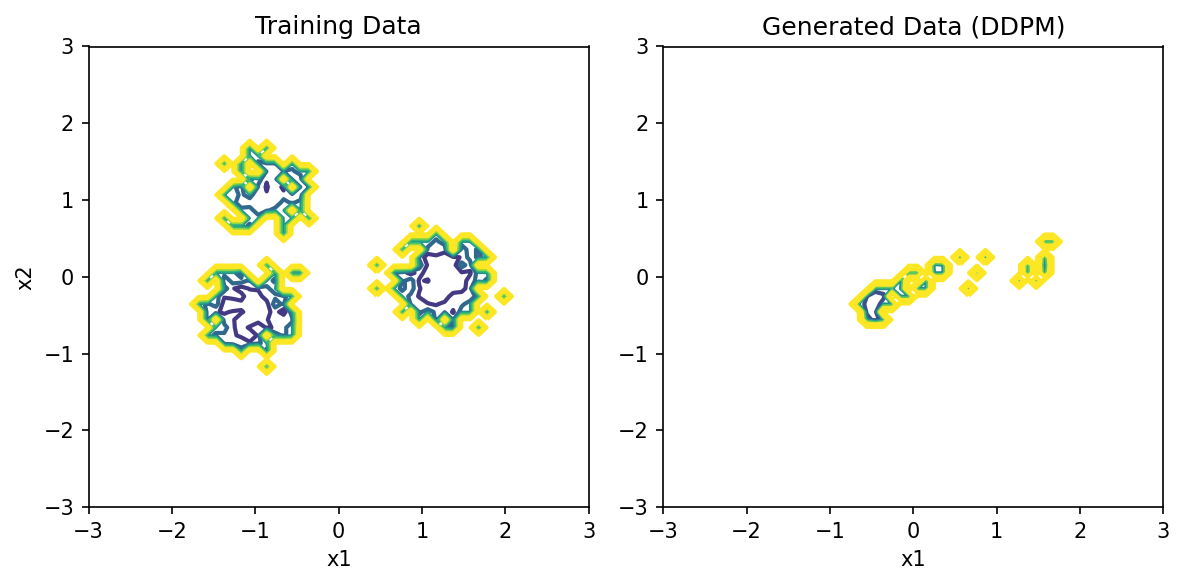

In [5]:
G_MD, xe_MD, ye_MD = utils.FE_hist(trainingpca, args.bounds, binw=0.1)
G_NF, xe_NF, ye_NF = utils.FE_hist(pca.transform(generated_testing), args.bounds, binw=0.1)

fig, axs = plt.subplots(1,2, figsize=(8,4), dpi=150, tight_layout=True);
axs[0].contour(G_MD.T, extent=[xe_MD[0], xe_MD[-1], ye_MD[0], ye_MD[-1]],
        linewidths=2, vmin = 0, vmax = 6)
axs[1].contour(G_NF.T, extent=[xe_NF[0], xe_NF[-1], ye_NF[0], ye_NF[-1]],
        linewidths=2, vmin = 0, vmax = 6)
axs[0].set_xlabel("x1")
axs[0].set_ylabel("x2")
axs[0].set_title("Training Data")
axs[1].set_xlabel("x1")
axs[1].set_title("Generated Data (DDPM)")
axs[0].set_xlim(args.bounds[0], args.bounds[1]);
axs[0].set_ylim(args.bounds[2], args.bounds[3]);
axs[1].set_xlim(args.bounds[0], args.bounds[1]);
axs[1].set_ylim(args.bounds[2], args.bounds[3]);